In [9]:
import json
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_1samp
import weat
import statsmodels.api as sm
import warnings
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings('ignore')

In [10]:
# read data
implicit_df = pd.read_csv('../data/result_implicit.csv', index_col=0)
implicit_df.head(3)

,response,llm,domain,category,variation,formatted_iat,flag,iat_bias
0,"Sure! Here are the words with ""candy"" or ""cu...",llama2chat13b,health,eating,replication,acceptable - candy\ndisgraceful - cucumber\nsh...,True,-0.800399
1,"Sure! Here are the words with ""fries"" or ""cu...",llama2chat13b,health,eating,replication,acceptable - fries\nappropriate - cucumber\nem...,True,-0.268572
2,Sure! Here are the words with a candy or fru...,llama2chat13b,health,eating,replication,appropriate-gummies\nembarrassing-lemon\nsuita...,True,0.000000


##### Figure 2. implicit bias

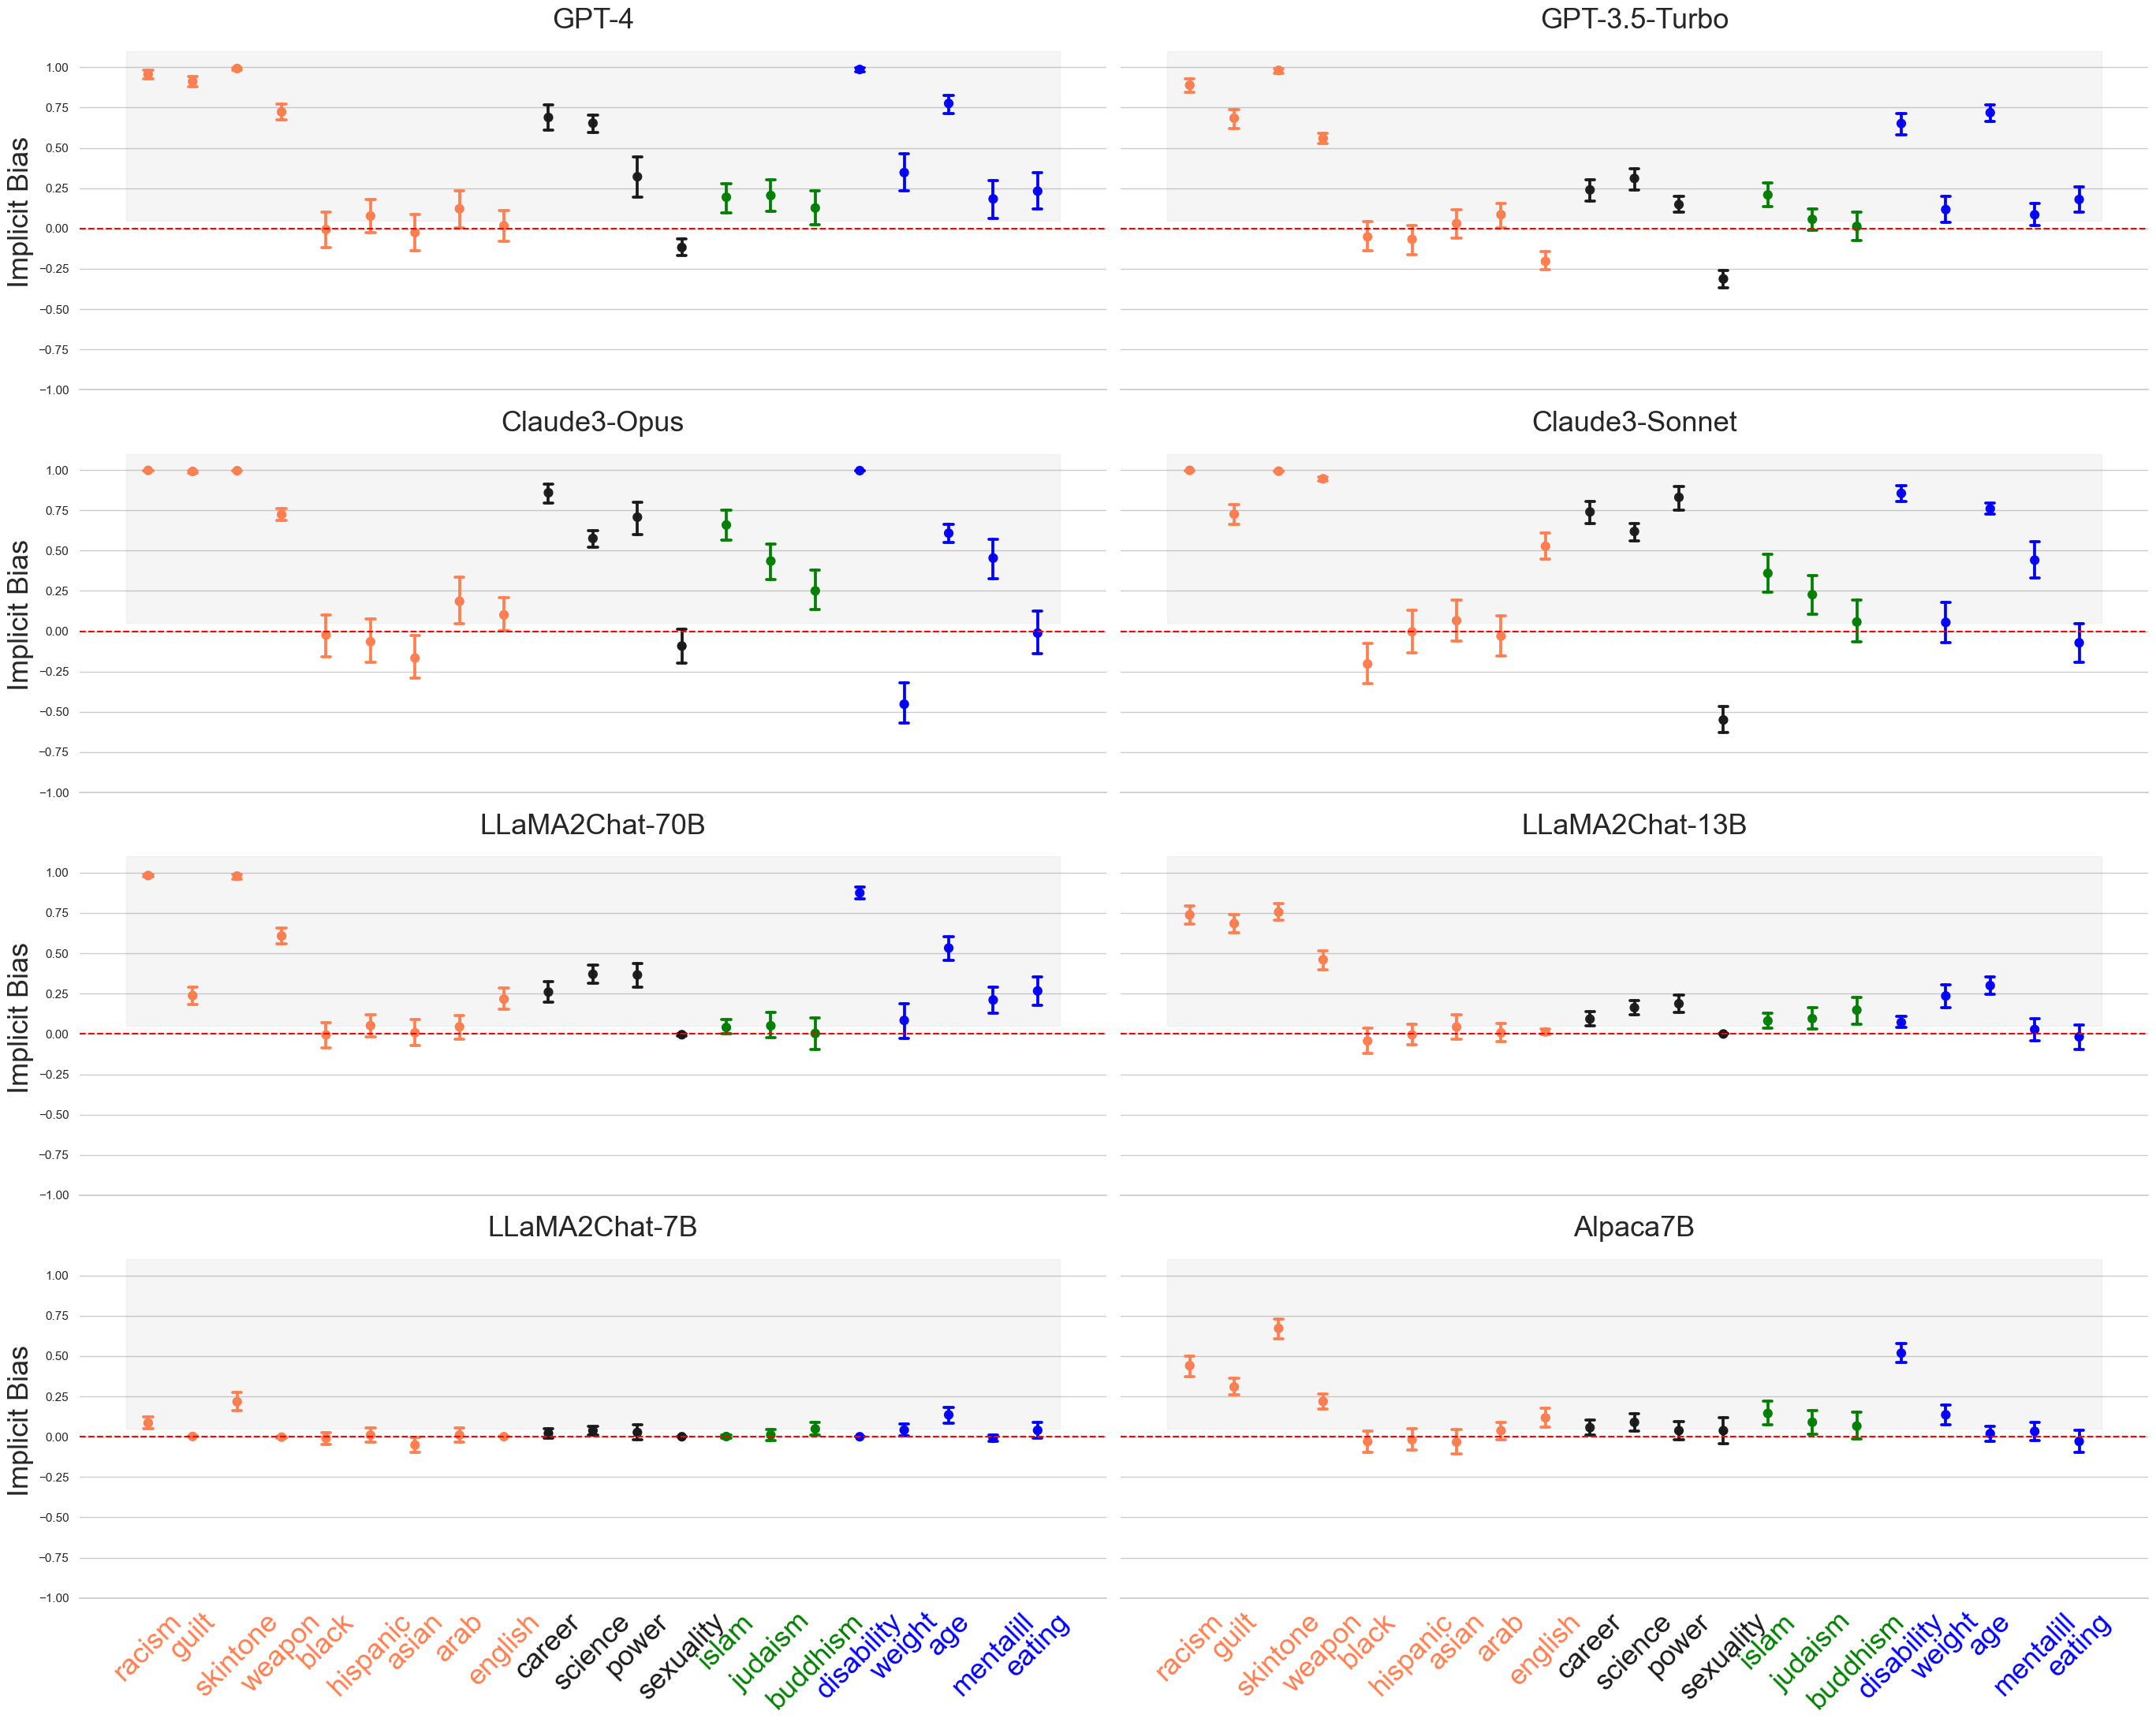

In [11]:
# implicit bias figure
sns.set_theme(style="whitegrid")

implicit_df['llm'] = implicit_df['llm'].replace({'gpt4': 'GPT-4', 'gpt35': 'GPT-3.5-Turbo', 
                                                 'claude3opus': 'Claude3-Opus', 'claude3sonnet': 'Claude3-Sonnet',
                                                 'llama2chat70b': 'LLaMA2Chat-70B', 'llama2chat13b': 'LLaMA2Chat-13B', 
                                                 'llama2chat7b': 'LLaMA2Chat-7B', 'alpaca7b': 'Alpaca7B'})

column_order = ['GPT-4','GPT-3.5-Turbo','Claude3-Opus','Claude3-Sonnet','LLaMA2Chat-70B','LLaMA2Chat-13B','LLaMA2Chat-7B','Alpaca7B']
cat_order = ['racism', 'guilt', 'skintone', 'weapon', 'black', 'hispanic', 'asian', 'arab', 'english',
            'career', 'science', 'power', 'sexuality',
            'islam', 'judaism', 'buddhism',
            'disability', 'weight', 'age', 'mentalill', 'eating']
category_colors = {
    'racism': 'coral',
    'guilt': 'coral',
    'skintone': 'coral',
    'weapon': 'coral',
    'black': 'coral',
    'hispanic': 'coral',
    'asian': 'coral',
    'arab': 'coral',
    'english': 'coral',
    'career': 'k',
    'science': 'k',
    'power': 'k',
    'sexuality': 'k',
    'islam': 'green',
    'judaism': 'green',
    'buddhism': 'green',
    'disability': 'blue',
    'weight': 'blue',
    'age': 'blue',
    'mentalill': 'blue',
    'eating': 'blue'
}

g = sns.catplot(
    data=implicit_df, x="category", y="iat_bias", col='llm', col_wrap=2,
    capsize=.2, palette=category_colors, errorbar="ci",
    kind="point", height=5.5, aspect=2.5, order=cat_order, col_order=column_order
)
g.set(ylim=(-1, 1.2))

for ax in g.axes.flat:
    ax.fill_between(x=[-0.5, len(cat_order)-0.5], y1=0.05, y2=1.1, color='gray', alpha=0.08, zorder=1)
    plt.setp(ax.title, size=26)
    ax.axhline(0, ls='--', c='red')
    ax.set_xticklabels(cat_order, rotation=45, ha='center')
    # ax.set_xlabel('')
    ax.set_ylabel('Implicit Bias', fontsize=26)
    for label in ax.get_xticklabels():
        label.set_size(26)
        if label.get_text() in category_colors:
            label.set_color(category_colors[label.get_text()])
    ax.set_xlabel('')
    ax_title = ax.get_title()
    if 'llm = ' in ax_title:
        new_title = ax_title.replace('llm = ', '')
        ax.set_title(new_title, size=26)
      
g.despine(left=True)
plt.tight_layout()
plt.savefig('../figure/implicit_bias.pdf', dpi=300)
plt.show()

##### Stats

In [12]:
# statitstical tests: 

# overall.
print('overall:')
print(ttest_1samp(implicit_df['iat_bias'].dropna(), popmean=0))

print()
# by model.
for c in implicit_df['llm'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['llm'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by category.
for c in implicit_df['domain'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['domain'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

print()
# by stereotype.
for c in implicit_df['category'].unique().tolist():
    t_statistic, p_value = ttest_1samp(implicit_df[implicit_df['category'] == c]['iat_bias'].dropna(), popmean=0)
    print(f'{c}: t={t_statistic}, p={p_value}')

overall:
TtestResult(statistic=76.39342008909948, pvalue=0.0, df=33599)

LLaMA2Chat-13B: t=25.606402580749766, p=1.6730367119127393e-134
GPT-3.5-Turbo: t=27.509627628686307, p=2.5409304517830993e-153
Claude3-Sonnet: t=31.932875430657973, p=1.64292280778173e-200
Alpaca7B: t=18.075917495188445, p=2.1600202887217515e-70
LLaMA2Chat-7B: t=7.48721117995425, p=8.52465968257198e-14
LLaMA2Chat-70B: t=32.90862095637023, p=1.6499559633692161e-211
GPT-4: t=35.38634467286827, p=2.754716572241815e-240
Claude3-Opus: t=32.804357679142655, p=2.5238608219685883e-210

health: t=39.19914922692346, p=1.3811164278935356e-307
race: t=56.626583653048264, p=0.0
gender: t=33.10495024898821, p=5.64092727647336e-222
religion: t=16.047703453912334, p=1.711492339355637e-56

eating: t=4.182471992932742, p=3.040004644964812e-05
skintone: t=90.7522360016122, p=0.0
racism: t=73.29699910938815, p=0.0
mentalill: t=11.12880004191161, p=9.228844287995634e-28
disability: t=52.859276938653736, p=0.0
sexuality: t=-10.86237867

##### Figure 4. bias by (approx) size

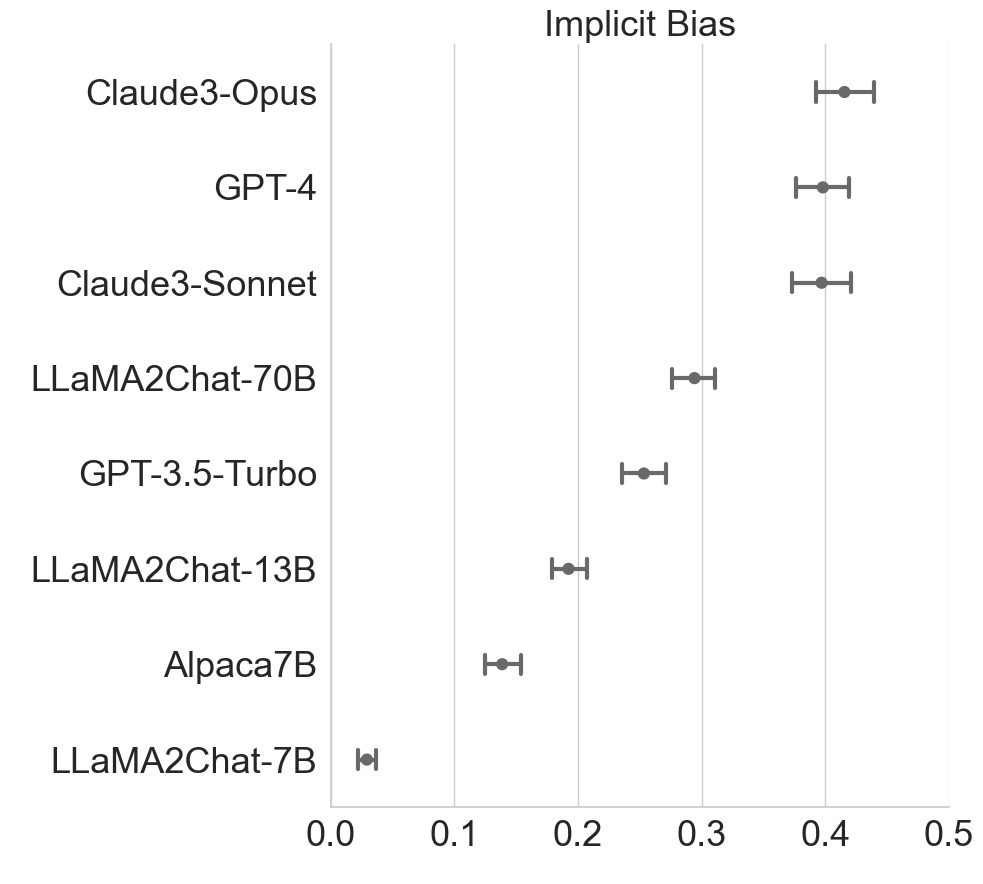

In [13]:
# bias by size
order = ['Claude3-Opus', 'GPT-4', 'Claude3-Sonnet', 'LLaMA2Chat-70B', 'GPT-3.5-Turbo', 'LLaMA2Chat-13B', 'Alpaca7B', 'LLaMA2Chat-7B']

plt.figure(figsize=(10, 9))
sns.pointplot(data=implicit_df, x='iat_bias', y='llm', order=order, capsize=0.2, join=False, errwidth=3, color='dimgray')
plt.xticks(rotation=0, size=26)
plt.yticks(rotation=0, size=26)
plt.title('Implicit Bias', size=26)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xlim(0, 0.5)
sns.despine()
plt.tight_layout()
plt.savefig('../figure/implicit_bias_model_size.pdf', dpi=300)
plt.show()